### QAOA with real data

QTFT Team, 23/05/2020
- No divide and conquer yet
- Communities are breakdown into <10 assets with greedy modularity and Louvian algorithms
- QAOA is simulated using tensor network and w-state anzat
- Linear relaxation is used as a classical benchmark

In [3]:
import numpy as np
from qaoa_tn import QAOA_TN, Relaxation, Exact
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import community
import random
#import func

Load data

In [6]:
As = sparse.load_npz('data/a_matrix.npz')
Qs = sparse.load_npz('data/q_matrix.npz')

Plot data histrogram

Distribution of A


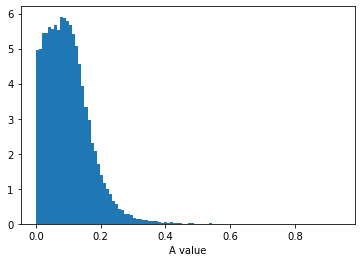

Distribution of Q


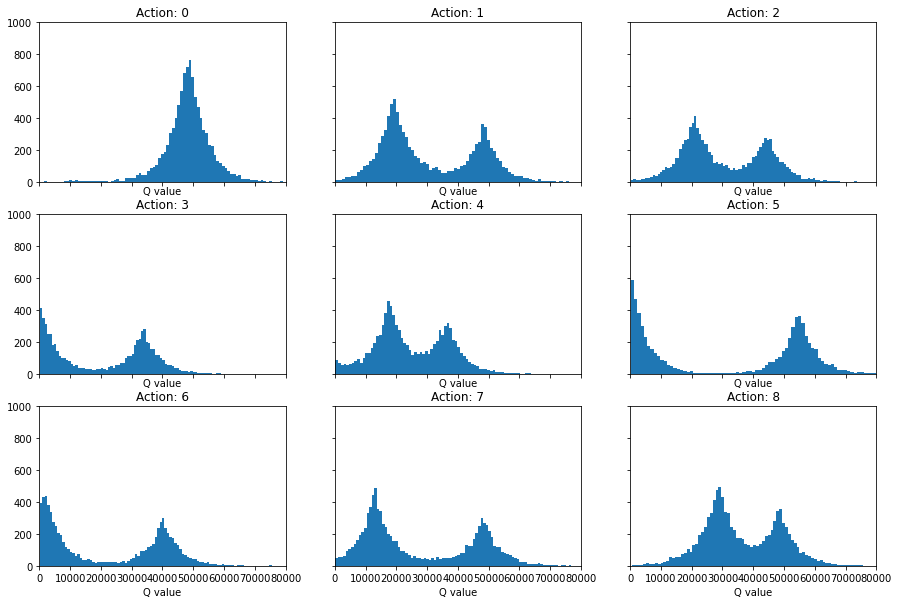

In [7]:
print("Distribution of A")
plt.figure()
_ = plt.hist(sparse.find(As)[2],density=True,bins=100)
plt.xlabel('A value')
plt.show()


print("Distribution of Q")
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True,figsize=(15, 10))

for i in range(3):
    for j in range(3):
        axs[i,j].hist(sparse.find(Qs[:,3*i+j])[2],bins=100)
        axs[i,j].set_xlim([0,80000])
        axs[i,j].set_ylim([0,1000])
        axs[i,j].set_title("Action: %d"%(3*i+j))
        axs[i,j].set_xlabel("Q value")
        
plt.show()

Create subgroup

Group size distribution according to greedy modularity algorithm


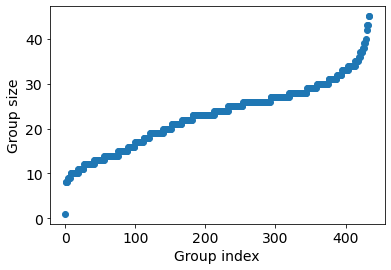

Size of the selected group: 20


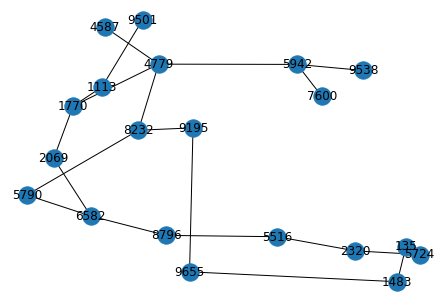

Subgroup size distribution according to Louvian algorithm 


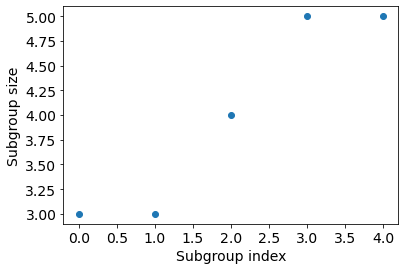

Size of the selected subgroup: 3


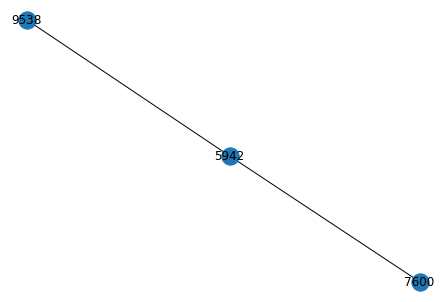

In [8]:
# Create cgroups using greedy modularity communities
As_nx = nx.from_scipy_sparse_matrix(As)
groups = nx.algorithms.community.modularity_max.greedy_modularity_communities(As_nx)

# Randomly select a group
idx = random.choice(groups)
G = As_nx.subgraph(idx)

# Create subgroups using Louvain algorithm
subgroups = community.best_partition(G)

# Randomly select a subgroup
keys = np.array(list(subgroups.keys()))
vals = np.array(list(subgroups.values()))
asset_idx = keys[np.where(vals==np.random.randint(max(vals)))[0]]
g = As_nx.subgraph(asset_idx)

print("Group size distribution according to greedy modularity algorithm")
plt.figure()
plt.plot(np.sort([len(x) for x in groups]),'o')
plt.xlabel('Group index',fontsize=14)
plt.ylabel('Group size',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


print("Size of the selected group: %d"%len(G))
plt.figure()
nx.draw(G, with_labels = True)
plt.show()


print("Subgroup size distribution according to Louvian algorithm ")
plt.figure()
plt.plot(np.sort(np.unique(vals,return_counts=True)[1]),'o')
plt.xlabel('Subgroup index',fontsize=14)
plt.ylabel('Subgroup size',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


print("Size of the selected subgroup: %d"%len(g))
plt.figure()
nx.draw(g, with_labels = True)
plt.show()

Create input's parameters

In [9]:
# Number of assets
N = len(asset_idx)

# Number of actions
M = 7

# Selected actions
action_idx = np.arange(M)

# Q values
Q = np.array(Qs[asset_idx][:,action_idx].todense()) / 8000

# A values
A = np.array(As[asset_idx][:,asset_idx].todense())
    
# epsilon
e = 1

# Number of cycles, the circuit layer "p"
cycles = 20

Run QAOA

In [10]:
qaoa = QAOA_TN(N, M, Q, A, e, cycles)
qaoa.optimized(maxiter=100,method='BFGS')

         Current function value: -18.904962
         Iterations: 100
         Function evaluations: 4510
         Gradient evaluations: 110


Run Linear Relaxation

In [15]:
linear = Relaxation(N, M, Q, A, e)
linear.optimized(maxiter=300)

`xtol` termination condition is satisfied.
Number of iterations: 128, function evaluations: 154, CG iterations: 0, optimality: 8.13e-02, constraint violation: 0.00e+00, execution time: 0.17 s.


Run Exact

In [16]:
exact = Exact(N, M, Q, A, e)
exact.optimized()

Plot the results

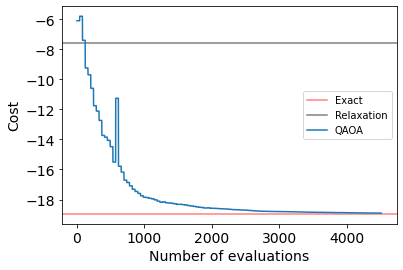

In [17]:
plt.axhline(y=exact.cost_min, linestyle='-',alpha=0.5,c='r',label='Exact')
plt.axhline(y=linear.cost_min, linestyle='-',alpha=0.5, c='k',label='Relaxation')
plt.plot(qaoa.costs, label='QAOA')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of evaluations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.legend()

In [14]:
7*20*5000/(60*60*24)

8.101851851851851